Importing libraries

In [2]:
import pybammeis
import pybamm
import os
import re
import numpy as np
from gamry_parser import GamryParser, Impedance
import pandas as pd
import time as timer
import matplotlib.pyplot as plt
from scipy.fft import fft
import random
from scipy.optimize import minimize
from scipy.optimize import basinhopping
from scipy.interpolate import interp1d
import pyswarms as ps 
from pyswarms.single import GlobalBestPSO

Uploading experimental data

In [48]:
# ved ca. 45% SoC 
# ved 25 deg C

def get_exp_data(i, d): 
    z_list = []
    file = "/Users/synnemard/Desktop/lithium_ion/EIS data/MJ1_01_EIS-SoC_01-05/MJ1_01_EIS-SoC_0"+str(i)+"/"+d+"EISGALV3V587.DTA"
    ca = Impedance(file)
    ca.load(filename=file)

    # extract EIS curve
    res = ca.get_curve_data().iloc[::-1]
    df_real = res['Zreal']
    df_imag= res['Zimag']
    freq = res['Freq']

    # Removing the points beneath the y-axis 
    real = df_real[df_imag <= 0]
    imag = df_imag[df_imag <= 0]
    
    # Adding the impendances to the list 
    z_list.append(real)
    z_list.append(imag)
    return(z_list)

#get_exp_data(1, "d")




Plotting

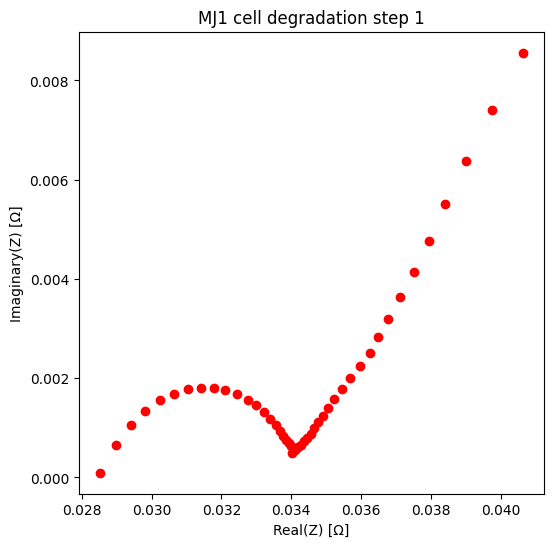

In [49]:
def plotting(i, d): 
    # Creating Nyquist plot
    plt.figure(figsize=(6,6))
    plt.scatter(get_exp_data(i, d)[0], -get_exp_data(i, d)[1], color='red') 

    # Labeling the plot
    plt.xlabel('Real(Z) [Ω]')
    plt.ylabel('Imaginary(Z) [Ω]')
    plt.title('MJ1 cell degradation step '+str(i))
    plt.show()

plotting(1, "")

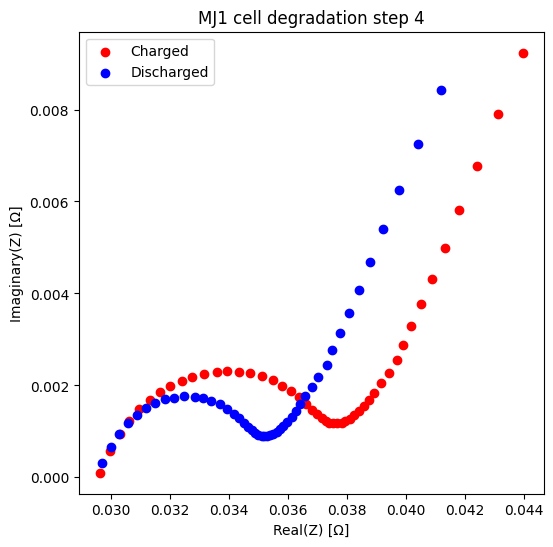

In [50]:
def combined_plot(i):
    # Creating the figure for both the charged and discharged data
    plt.figure(figsize=(6, 6))

    z_list_charged = get_exp_data(i, "")
    z_list_discharged = get_exp_data(i, "d")

    # Plot 
    plt.scatter(z_list_charged[0], -z_list_charged[1], color='red', label='Charged')
    plt.scatter(z_list_discharged[0], -z_list_discharged[1], color='blue', label='Discharged')

    # Adding labels and title
    plt.xlabel('Real(Z) [Ω]')
    plt.ylabel('Imaginary(Z) [Ω]')
    plt.title(f'MJ1 cell degradation step {i}')
    plt.legend()
    plt.show()

combined_plot(4)
